#Connect to drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Import libraries

In [ ]:
seed=42
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.io
import numpy as np
import os
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
import tensorflow.keras as tfk
import tensorflow.keras.layers as tfkl

from tensorflow.keras.models import save_model, load_model

#Universal variables

In [ ]:
numero_cicli=2
fs=128
bpm_min=40
lunghezza_max=int(60*numero_cicli*fs/bpm_min)
input_shape = [lunghezza_max,1]
input_shape2 = [int(lunghezza_max/2),1] #fft input
stats = [10,1] #stats input
batch_size = 256
epochs = 50
LR = 0.0001
patience_ES = 20
patience_LR = 20
factor_LR = 0.5

#Load

In [ ]:
val_single_peaks_V = np.load('/content/drive/MyDrive/APPLED_AI_ASSIGMENT/FINAL_DATA/validation_single_peaks_V.npy',allow_pickle=True)
val_single_peaks_S = np.load('/content/drive/MyDrive/APPLED_AI_ASSIGMENT/FINAL_DATA/validation_single_peaks_S.npy',allow_pickle=True)
val_single_peaks_N = np.load('/content/drive/MyDrive/APPLED_AI_ASSIGMENT/FINAL_DATA/validation_single_peaks_N.npy',allow_pickle=True)

val_diff_amp_S = np.load('/content/drive/MyDrive/APPLED_AI_ASSIGMENT/SIGNALS_STATISTIC/diff_amp_val_S.npy')
val_diff_amp_V = np.load('/content/drive/MyDrive/APPLED_AI_ASSIGMENT/SIGNALS_STATISTIC/diff_amp_val_V.npy')
val_diff_p_s_S = np.load('/content/drive/MyDrive/APPLED_AI_ASSIGMENT/SIGNALS_STATISTIC/diff_p_s_val_S.npy')
val_diff_p_s_V = np.load('/content/drive/MyDrive/APPLED_AI_ASSIGMENT/SIGNALS_STATISTIC/diff_p_s_val_V.npy')
val_entr_S = np.load('/content/drive/MyDrive/APPLED_AI_ASSIGMENT/SIGNALS_STATISTIC/entr_val_S.npy')
val_entr_V = np.load('/content/drive/MyDrive/APPLED_AI_ASSIGMENT/SIGNALS_STATISTIC/entr_val_V.npy')
val_kurt_S = np.load('/content/drive/MyDrive/APPLED_AI_ASSIGMENT/SIGNALS_STATISTIC/kurt_val_S.npy')
val_kurt_V = np.load('/content/drive/MyDrive/APPLED_AI_ASSIGMENT/SIGNALS_STATISTIC/kurt_val_V.npy')
val_mean_S = np.load('/content/drive/MyDrive/APPLED_AI_ASSIGMENT/SIGNALS_STATISTIC/media_val_S.npy')
val_mean_V = np.load('/content/drive/MyDrive/APPLED_AI_ASSIGMENT/SIGNALS_STATISTIC/media_val_V.npy')
val_rms_S = np.load('/content/drive/MyDrive/APPLED_AI_ASSIGMENT/SIGNALS_STATISTIC/rms_val_S.npy')
val_rms_V = np.load('/content/drive/MyDrive/APPLED_AI_ASSIGMENT/SIGNALS_STATISTIC/rms_val_V.npy')
val_skew_S = np.load('/content/drive/MyDrive/APPLED_AI_ASSIGMENT/SIGNALS_STATISTIC/skew_val_S.npy')
val_skew_V = np.load('/content/drive/MyDrive/APPLED_AI_ASSIGMENT/SIGNALS_STATISTIC/skew_val_V.npy')
val_std_S = np.load('/content/drive/MyDrive/APPLED_AI_ASSIGMENT/SIGNALS_STATISTIC/stand_dev_val_S.npy')
val_std_V = np.load('/content/drive/MyDrive/APPLED_AI_ASSIGMENT/SIGNALS_STATISTIC/stand_dev_val_V.npy')
val_diff_amp_N = np.load('/content/drive/MyDrive/APPLED_AI_ASSIGMENT/SIGNALS_STATISTIC/diff_amp_val_N.npy')
val_diff_p_s_N = np.load('/content/drive/MyDrive/APPLED_AI_ASSIGMENT/SIGNALS_STATISTIC/diff_p_s_val_N.npy')
val_entr_N = np.load('/content/drive/MyDrive/APPLED_AI_ASSIGMENT/SIGNALS_STATISTIC/entr_val_N.npy')
val_kurt_N = np.load('/content/drive/MyDrive/APPLED_AI_ASSIGMENT/SIGNALS_STATISTIC/kurt_val_N.npy')
val_mean_N = np.load('/content/drive/MyDrive/APPLED_AI_ASSIGMENT/SIGNALS_STATISTIC/media_val_N.npy')
val_rms_N = np.load('/content/drive/MyDrive/APPLED_AI_ASSIGMENT/SIGNALS_STATISTIC/rms_val_N.npy')
val_skew_N = np.load('/content/drive/MyDrive/APPLED_AI_ASSIGMENT/SIGNALS_STATISTIC/skew_val_N.npy')
val_std_N = np.load('/content/drive/MyDrive/APPLED_AI_ASSIGMENT/SIGNALS_STATISTIC/stand_dev_val_N.npy')

In [ ]:
max=229
min=23
def merge_stats(N,a,b,c,d,e,f,g,h):
  final = [0]*N
  temp = []
  for i in range(N): #for the different signal

    temp.append([a[i][0],a[i][1],(b[i][0]-min)/(max-min),(b[i][1]-min)/(max-min),c[i],d[i],e[i],f[i],g[i],h[i]])
    final[i] = temp
    temp = []
  return np.array(final)

In [ ]:
val_stats_S = np.squeeze(merge_stats(val_diff_p_s_S.shape[0], val_diff_amp_S, val_diff_p_s_S, val_entr_S, val_kurt_S, val_mean_S, val_rms_S, val_skew_S, val_std_S))
val_stats_V = np.squeeze(merge_stats(val_diff_p_s_V.shape[0], val_diff_amp_V, val_diff_p_s_V, val_entr_V, val_kurt_V, val_mean_V, val_rms_V, val_skew_V, val_std_V))
val_stats_N = np.squeeze(merge_stats(val_diff_p_s_N.shape[0], val_diff_amp_N, val_diff_p_s_N, val_entr_N, val_kurt_N, val_mean_N, val_rms_N, val_skew_N, val_std_N))

In [ ]:
X=np.concatenate([val_single_peaks_N,val_single_peaks_S,val_single_peaks_V],axis=0)
y_binary=np.concatenate([np.zeros(val_single_peaks_N.shape[0]),np.ones(val_single_peaks_S.shape[0]+val_single_peaks_V.shape[0])],axis=0)
y_tri=np.concatenate([np.zeros(val_single_peaks_N.shape[0]),np.ones(val_single_peaks_S.shape[0]),2*np.ones(val_single_peaks_V.shape[0])],axis=0)
stats=np.concatenate([val_stats_N,val_stats_S,val_stats_V],axis=0)

In [ ]:
#function that zero pads single_peaks_X in order to obtain the same length for all the signals
#we thought that streatch the signals would modify them too much
def zero_pad_signals(single_peaks_X,lunghezza_max=384):
  single_peaks_X_new=[]
  for i in range(single_peaks_X.shape[0]):
    difference=lunghezza_max-single_peaks_X[i].shape[0]
    if difference%2==0:
      new_signal=np.concatenate([np.zeros(int(difference//2)),single_peaks_X[i],np.zeros(int(difference//2))],axis=0)
    else:
      new_signal=np.concatenate([np.zeros(int(difference//2)),single_peaks_X[i],np.zeros(int(difference//2+1))],axis=0)
    single_peaks_X_new.append(new_signal)
  return np.array(single_peaks_X_new)

In [ ]:
X=zero_pad_signals(X)

#FFT

In [ ]:
def compute_fft(X_test):
  X_fft_test=[]
  window=384
  for i in range(X_test.shape[0]):
    finestra=np.squeeze(X_test[i])
    X_fft_test.append(np.abs(np.fft.fft(finestra-np.mean(finestra))))  #MESSO ABS PERCHE' SENNO BUTTAVA VIA LA PARTE IMMAGINARIA
  X_fft_test=np.array(X_fft_test)
  freqs = np.linspace(0,1,window) #frequencies go from 0 to
  X_fft_test=X_fft_test[:,:window//2]
  return X_fft_test

In [ ]:
X_fft=compute_fft(X)

#Load models

In [ ]:
model1 = load_model('/content/drive/MyDrive/APPLED_AI_ASSIGMENT/TRAIN_ENSEMBLE/ENSAMBLE1')
model2 = load_model('/content/drive/MyDrive/APPLED_AI_ASSIGMENT/TRAIN_ENSEMBLE/ENSAMBLE2')
model3 = load_model('/content/drive/MyDrive/APPLED_AI_ASSIGMENT/TRAIN_ENSEMBLE/ENSAMBLE3')
model4 = load_model('/content/drive/MyDrive/APPLED_AI_ASSIGMENT/TRAIN_ENSEMBLE/ENSAMBLE4')
model5 = load_model('/content/drive/MyDrive/APPLED_AI_ASSIGMENT/TRAIN_ENSEMBLE/ENSAMBLE5')

modelSV = load_model('/content/drive/MyDrive/APPLED_AI_ASSIGMENT/MODELLI/BID_FREQ_STATS')

#First prediction

In [ ]:
indici=np.zeros(y_post.shape[0])

In [ ]:
y1=model1.predict(X)
y2=model2.predict(X)
y3=model3.predict(X)
y4=model4.predict(X)
y5=model5.predict(X)

1270/1270 [==============================] - 26s 20ms/step


In [ ]:
def postprocess(y,thres=0.75):
  y_post=[]
  for i in range(y.shape[0]):
    if y[i]<thres:
      y_post.append(0)
    else:
      y_post.append(1)
  return np.array(y_post)

In [ ]:
y=[]
for i in range(y1.shape[0]):
  y.append(np.mean([y1[i],y4[i],y2[i],y3[i],y5[i]]))#
y=np.array(y)

In [ ]:
y_01=postprocess(y,thres=0.1)
y_02=postprocess(y,thres=0.2)
y_03=postprocess(y,thres=0.3)
y_04=postprocess(y,thres=0.4)
y_05=postprocess(y,thres=0.5)
y_06=postprocess(y,thres=0.6)
y_07=postprocess(y,thres=0.7)
y_08=postprocess(y,thres=0.8)
y_09=postprocess(y,thres=0.9)
y_10=postprocess(y,thres=1)

FPR=[0]
TPR=[0]
for y_post_roc in [y_01,y_02,y_03,y_04,y_05,y_06,y_07,y_08,y_09,y_10]:
  conf_N_baseline= 0.5  #ratio of healthy peaks in respect to total ones in the whole dataset
  confidenza_1=[conf_N_baseline]
  risultati_1=[0]
  risultati_1_nome=['N'] # il primo viene scartato a priori da extract peaks e qui lo rimettiamo come predizione

  # 0 -> class N
  # 1 -> class SV
  k=-1
  for i in range(indici.shape[0]):
    k+=1
    if indici[i]==0: #modello ha predetto
      risultati_1.append(y_post_roc[k])
      if y_post_roc[k]==1:
        confidenza_1.append(y[k])
        risultati_1_nome.append('SV')
      else:
        confidenza_1.append(1-y[k])
        risultati_1_nome.append('N')
    else:
      confidenza_1.append(conf_N_baseline)
      risultati_1.append(0)
      risultati_1_nome.append('N')
      k=k-1

  confidenza_1.append(conf_N_baseline)
  risultati_1.append(0)
  risultati_1_nome.append('N')
  TP=0
  TN=0
  FP=0
  FN=0
  for i in range(y_binary.shape[0]):
    if y_binary[i]==0:
      if risultati_1[i]==0:
        TP+=1
      else:
        FN+=1
    else:
      if risultati_1[i]==0:
        FP+=1
      else:
        TN+=1
  fpr=FP/(FP+TN)
  tpr=TP/(TP+FN)
  TPR.append(tpr)
  FPR.append(fpr)

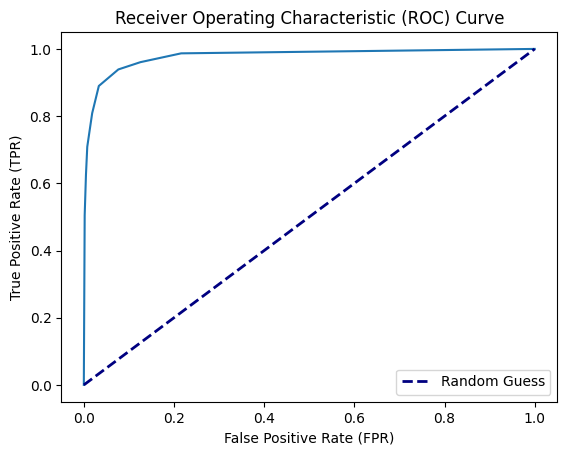

In [ ]:
plt.plot(FPR,TPR)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
y_post=postprocess(y)

In [ ]:
conf_N_baseline= 0.5  #ratio of healthy peaks in respect to total ones in the whole dataset
confidenza_1=[]
risultati_1=[]
risultati_1_nome=[] # il primo viene scartato a priori da extract peaks e qui lo rimettiamo come predizione

# 0 -> class N
# 1 -> class SV
k=-1
for i in range(indici.shape[0]):
  k+=1
  if indici[i]==0: #modello ha predetto
    risultati_1.append(y_post[k])
    if y_post[k]==1:
      confidenza_1.append(y[k])
      risultati_1_nome.append('SV')
    else:
      confidenza_1.append((1-y[k])*(2/3)+(1/3))
      risultati_1_nome.append('N')
  else:
    confidenza_1.append(conf_N_baseline)
    risultati_1.append(0)
    risultati_1_nome.append('N')
    k=k-1


In [ ]:
paz_result=[]
for i in range(len(y_binary)):
  if y_binary[i]=='N':
    paz_result.append(0)
  else:
    paz_result.append(1)
paz_result=np.array(paz_result)

              precision    recall  f1-score   support

         0.0       0.99      0.95      0.97     38511
         1.0       0.50      0.91      0.65      2103

    accuracy                           0.95     40614
   macro avg       0.75      0.93      0.81     40614
weighted avg       0.97      0.95      0.96     40614



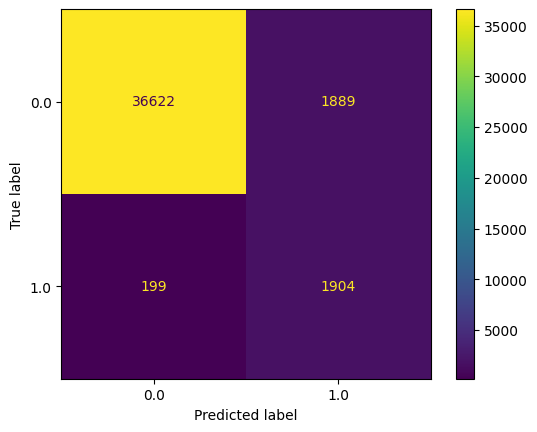

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
ConfusionMatrixDisplay.from_predictions(y_binary,risultati_1)

print(classification_report(y_binary,risultati_1))

#Second prediction

In [ ]:
conf_N_baseline= 0.33 #ratio of healthy peaks in respect to total ones in the whole dataset
confidenza_2=confidenza_1.copy
risultati_2=(risultati_1).copy
risultati_2_nome=(risultati_1_nome).copy

In [ ]:
#[1,0]->S
#[0,1]->V
k=-1
for i in range(indici.shape[0]):
  k+=1
  if indici[i]==0: #modello1 ha predetto
    if y_post[i]==1:
      primo=tf.convert_to_tensor(np.reshape(X[k],(1,384)),dtype=tf.float32)
      secondo=tf.convert_to_tensor(np.reshape(X_fft[k],(1,192)),dtype=tf.float32)
      terzo=tf.convert_to_tensor(np.reshape(stats[k],(1,10)),dtype=tf.float32)
      y2=modelSV([primo,secondo,terzo])
      y2_post=np.argmax(y2,axis=-1)
      if y2_post==0:
        confidenza_2[i]=np.array(y2)[0][0]*confidenza_1[i]
        risultati_2_nome[i]='S'
        risultati_2[i]=1
      else:
        confidenza_2[i]=np.array(y2)[0][1]*confidenza_1[i]
        risultati_2_nome[i]='V'
        risultati_2[i]=2
  else:
    confidenza_2[i]=conf_N_baseline
    k=k-1

Accuracy: 0.7211476466795615

Recall N: 0.994994994994995
Recall S: 0.698019801980198
Recall V: 0.44556677890011226

Precision N: 0.8331936295054484
Precision S: 0.6828087167070218
Precision V: 0.5925373134328358


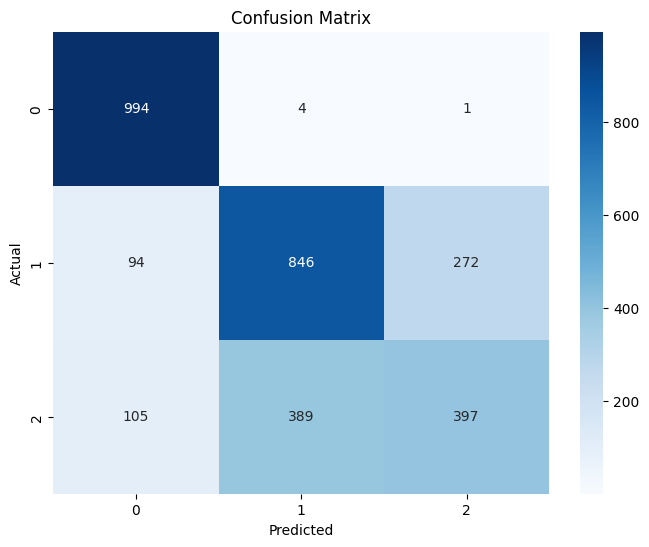

In [ ]:
# prima lettera VERO, seconda lettera PREDETTO
NN=0
NS=0
NV=0
SN=0
SS=0
SV=0
VN=0
VS=0
VV=0
SOGLIA=True
soglia=1000
contatore=0
for i in range(y_tri.shape[0]):
  vero=y_tri[i]
  if int(vero)==0:
    contatore +=1
    if SOGLIA:
      if contatore<soglia:
        predetto=risultati_2_nome[i]
        if predetto=='N':
          NN+=1
        elif predetto=='S':
          NS+=1
        else:
          NV+=1
    else:
      predetto=risultati_2_nome[i]
      if predetto=='N':
        NN+=1
      elif predetto=='S':
        NS+=1
      else:
        NV+=1
  elif int(vero)==1:
    predetto=risultati_2_nome[i]
    if predetto=='N':
      SN+=1
    elif predetto=='S':
      SS+=1
    else:
      SV+=1
  else:
    predetto=risultati_2_nome[i]
    if predetto=='N':
      VN+=1
    elif predetto=='S':
      VS+=1
    else:
      VV+=1
confusion_matrix=[[NN,NS,NV],[SN,SS,SV],[VN,VS,VV]]
recall_N=NN/(NN+NS+NV)
precision_N=(NN)/(NN+SN+VN)
recall_S=(SS)/(SS+SN+SV)
precision_S=(SS)/(SS+NS+VS)
recall_V=(VV)/(VV+VS+VN)
precision_V=(VV)/(VV+SV+NV)
recall_per_class=[recall_N,recall_S,recall_V]
precision_per_class=[precision_N,precision_S,precision_V]
accuracy=(NN+SS+VV)/(NN+NS+NV+SS+SN+SV+VV+VN+VS)

print('Accuracy:',accuracy)
print()
print('Recall N:',recall_N)
print('Recall S:',recall_S)
print('Recall V:',recall_V)
print()
print('Precision N:',precision_N)
print('Precision S:',precision_S)
print('Precision V:',precision_V)

import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
np.mean(np.array(confidenza_2))

0.8536964263029541

Accuracy: 0.932313980400847

Recall N: 0.9509490794837838
Recall S: 0.698019801980198
Recall V: 0.44556677890011226

Precision N: 0.9945954754080552
Precision S: 0.33399131464666404
Precision V: 0.31507936507936507


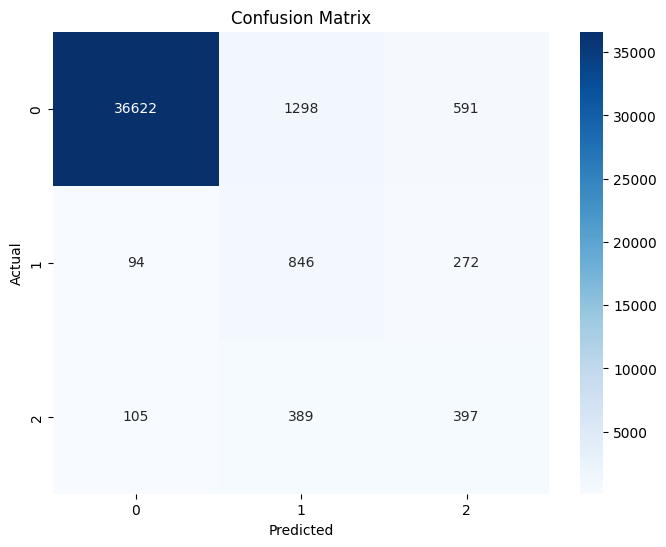

In [ ]:
# prima lettera VERO, seconda lettera PREDETTO
NN=0
NS=0
NV=0
SN=0
SS=0
SV=0
VN=0
VS=0
VV=0
SOGLIA=False
soglia=2000
contatore=0
for i in range(y_tri.shape[0]):
  vero=y_tri[i]
  if int(vero)==0:
    contatore +=1
    if SOGLIA:
      if contatore<soglia:
        predetto=risultati_2_nome[i]
        if predetto=='N':
          NN+=1
        elif predetto=='S':
          NS+=1
        else:
          NV+=1
    else:
      predetto=risultati_2_nome[i]
      if predetto=='N':
        NN+=1
      elif predetto=='S':
        NS+=1
      else:
        NV+=1
  elif int(vero)==1:
    predetto=risultati_2_nome[i]
    if predetto=='N':
      SN+=1
    elif predetto=='S':
      SS+=1
    else:
      SV+=1
  else:
    predetto=risultati_2_nome[i]
    if predetto=='N':
      VN+=1
    elif predetto=='S':
      VS+=1
    else:
      VV+=1
confusion_matrix=[[NN,NS,NV],[SN,SS,SV],[VN,VS,VV]]
recall_N=NN/(NN+NS+NV)
precision_N=(NN)/(NN+SN+VN)
recall_S=(SS)/(SS+SN+SV)
precision_S=(SS)/(SS+NS+VS)
recall_V=(VV)/(VV+VS+VN)
precision_V=(VV)/(VV+SV+NV)
recall_per_class=[recall_N,recall_S,recall_V]
precision_per_class=[precision_N,precision_S,precision_V]
accuracy=(NN+SS+VV)/(NN+NS+NV+SS+SN+SV+VV+VN+VS)

print('Accuracy:',accuracy)
print()
print('Recall N:',recall_N)
print('Recall S:',recall_S)
print('Recall V:',recall_V)
print()
print('Precision N:',precision_N)
print('Precision S:',precision_S)
print('Precision V:',precision_V)

import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
for i in range(-200,-100):
  campione=i
  predizione=risultati_1_nome[campione]
  conf=confidenza_1[campione]
  if predizione=='N':
    print(predizione,'   ',conf)
    print()

N     0.7828613519668579

N     0.7023283243179321

N     0.6132980187733967

N     0.5624103943506876

N     0.7512882947921753

N     0.5260584751764933

N     0.6268023252487183

N     0.5927791198094685

N     0.6054386297861735

N     0.5515737930933634

N     0.5703263680140177

N     0.7009964386622111

N     0.5516101121902466

N     0.5795907974243164

N     0.5734837452570597

N     0.5121639966964722

N     0.5017652908960978

N     0.6948472062746683



In [ ]:
for i in range(100,200):
  campione=i
  predizione=risultati_2_nome[campione]
  conf=confidenza_2[campione]
  print(predizione,'   ',conf)
  print()

N     0.9845387128492196

N     0.9845317813257375

N     0.9845314448078473

N     0.9821798739333947

N     0.9844242272277672

N     0.983183426161607

N     0.9826210339864094

N     0.9828362402816613

N     0.9834803231060505

N     0.9837104951341946

N     0.9849782983462014

N     0.9803482219576836

N     0.9810682361324627

N     0.9803534311552842

N     0.9814050172766049

N     0.9782309134801228

N     0.9817848640183606

N     0.9833274284998574

N     0.9873397598663964

N     0.9872548393905163

N     0.9820472871263821

N     0.9812533060709634

N     0.9883508806427319

N     0.9870806969702244

N     0.9892272589107354

N     0.9886403791606426

N     0.9907171117762723

N     0.9919811567912498

N     0.9926927306999762

N     0.9912529786427815

N     0.9931175392121077

N     0.9923009239137173

N     0.992775029192368

N     0.99294892201821

N     0.9938747299214203

N     0.992865301668644

N     0.9953698298583427

N     0.9945163136969009

N     0.995368344